In [222]:
from model import create_model
from train import *

import torch

forward_features, backward_features = 0, 60
model = create_model(13, forward_features + backward_features, 4, 5)

model.load_state_dict(torch.load(r"C:\Users\Austin\Desktop\Desktop Projects\flash\models\model_p7_f0_b60_e947.mdl", weights_only=True))

model.eval()

4 60 13
16 60 1
32 56 1
32 28.0 1
64 24.0 1
64 12.0 1
768.0


Sequential(
  (Conv1): Conv2d(4, 16, kernel_size=(1, 13), stride=(1, 1))
  (Conv2): Conv2d(16, 32, kernel_size=(5, 1), stride=(1, 1))
  (ReLU1): ReLU()
  (MaxPool1): MaxPool2d(kernel_size=(2, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv3): Conv2d(32, 64, kernel_size=(5, 1), stride=(1, 1))
  (ReLU2): ReLU()
  (MaxPool2): MaxPool2d(kernel_size=(2, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Dropout): Dropout(p=0.2, inplace=False)
  (FC1): Linear(in_features=768, out_features=512, bias=True)
  (ReLU3): ReLU()
  (FC2): Linear(in_features=512, out_features=128, bias=True)
  (ReLU4): ReLU()
  (FC3): Linear(in_features=128, out_features=6, bias=True)
)

In [184]:
import numpy as np

def display_forecast(forecast_tensor, forecast_date):
    AWND = float(forecast_tensor[0])
    PRCP = float(forecast_tensor[1])
    TMAX = float(forecast_tensor[2])
    TMIN = float(forecast_tensor[3])
    UWSF12 = float(forecast_tensor[4])
    VWSF12 = float(forecast_tensor[5])

    print('======================================')
    print(f'Forecast for {forecast_date}:')
    print(f'Average wind speed: {AWND} mph')
    print(f'Expected precipitation: {PRCP} hundredths in.')
    print(f'High temperature: {TMAX} deg F')
    print(f'Low temperature: {TMIN} deg F')
    print(f'Eastward wind gust speed: {UWSF12} mph')
    print(f'Northward wind gust speed: {VWSF12} mph')
    print('======================================')

def normal_clamp_forecast(forecast_tensor, normals):
    AWND = float(forecast_tensor[0])
    PRCP = float(forecast_tensor[1])
    TMAX = float(forecast_tensor[2])
    TMIN = float(forecast_tensor[3])
    UWSF12 = float(forecast_tensor[4])
    VWSF12 = float(forecast_tensor[5])

    AWND_normal = float(normals[0])
    PRCP_normal = float(normals[1])
    TMAX_normal = float(normals[2])
    TMIN_normal = float(normals[3])
    UWSF12_normal = float(normals[4])
    VWSF12_normal = float(normals[5])

    clamp = lambda x, min_val, max_val: min(max_val, max(x, min_val))
    
    AWND = clamp(AWND, 0, 4 * AWND_normal)
    PRCP = clamp(PRCP, 0, 100 * PRCP_normal)
    TMAX = clamp(TMAX, TMIN + 1, 2 * abs(TMAX_normal))
    TMIN = clamp(TMIN, -2 * abs(TMIN_normal), TMAX - 1)
    UWSF12 = clamp(UWSF12, -4 * abs(UWSF12_normal), 4 * abs(UWSF12_normal))
    VWSF12 = clamp(VWSF12, -4 * abs(VWSF12_normal), 4 * abs(VWSF12_normal))

    return torch.tensor((AWND, PRCP, TMAX, TMIN, UWSF12, VWSF12))

def create_derived_values_from_forecast(forecast_tensor, forecast_date):
    AWND = float(forecast_tensor[0])
    PRCP = float(forecast_tensor[1])
    TMAX = float(forecast_tensor[2])
    TMIN = float(forecast_tensor[3])
    UWSF12 = float(forecast_tensor[4])
    VWSF12 = float(forecast_tensor[5])
    
    TAVG = (TMAX + TMIN) / 2

    if abs(UWSF12) < 0.05:
        WDF12 = 0.0 if VWSF12 > 0 else np.pi
        WSF12 = VWSF12
    elif abs(UWSF12) < 0.05:
        WDF12 = np.pi / 2 if VWSF12 > 0 else 3* np.pi / 2
        WSF12 = UWSF12
    else:
        WDF12 = np.arctan(VWSF12 / UWSF12)
        WSF12 = UWSF12 / np.cos(WDF12)

    DAY365 = pd.to_datetime(forecast_date).day_of_year / 365.25
    SIN = np.sin(2 * np.pi * DAY365)
    COS = np.cos(2 * np.pi * DAY365)
    
    TSPREAD = TMAX - TMIN
    WSPREAD = WSF12 - AWND

    return torch.tensor((AWND, PRCP, TMAX, TMIN, UWSF12, VWSF12, TAVG, WDF12, WSF12, DAY365, SIN, COS, TSPREAD, WSPREAD))

def fetch_normals_for_date(normals, forecast_date):
    mean_columns = [x for x in normals.columns if 'mean' in x]
    day = forecast_date.day_of_year
    day = day if day < 366 else 1
    means = normals[mean_columns].loc[day]
    return torch.from_numpy(means.values)
    

In [186]:
def create_forecast(model, historical, normals, forecast_start, forecast_length):
    t, dl = create_tensors(historical, normals)
    
    forecast_start_idx = dl[forecast_start]
    historical_data_start = forecast_start_idx - 60
    historical_data_end = forecast_start_idx - 1
    
    current_lookback = get_many_historical_features(historical_data_start, historical_data_end, t.float(), dl, input=True)
    
    forecast = []

    start_date = pd.to_datetime(forecast_start)
    for i in range(forecast_length):
        current_date = start_date + pd.Timedelta(days=i)
        prediction = model(current_lookback.unsqueeze(0))[0]
        
        daily_means = fetch_normals_for_date(normals, current_date)
        clamped_prediction = normal_clamp_forecast(prediction, daily_means)
        forecast.append(clamped_prediction)
        
        #display_forecast(clamped_prediction, current_date)

        extended_prediction = create_derived_values_from_forecast(clamped_prediction, current_date)
        difference = extended_prediction - daily_means
        squared = difference * difference

        features = torch.stack((extended_prediction.unsqueeze(0), 
                                daily_means.unsqueeze(0), 
                                difference.unsqueeze(0), 
                                squared.unsqueeze(0)), dim=0)

        #print(features.size())

        current_lookback = torch.concat((current_lookback[:, 1:], features.float()), dim=1)

    return torch.stack(forecast, dim=0)

    

In [198]:
def get_forecasted_period_from_historical(historical, normals, forecast_start, forecast_length):
    t, dl = create_tensors(historical, normals)
    
    forecast_start_idx = dl[forecast_start]
    forecast_end_idx = forecast_start_idx + forecast_length - 1

    actual_features = get_many_historical_features(forecast_start_idx, forecast_end_idx, t.float(), dl, input=False)
    
    return actual_features
    #actual_observations = actual_features[:, 0]


In [202]:
historical_data = r"data\grand_island_nwt.csv"
normals_data = r"data\grand_island_normals.csv"

historical = pd.read_csv(historical_data)
normals = pd.read_csv(normals_data)
normals.insert(0, 'DAY', normals.index)

weeks = 64
start_date = '2012-01-01'

days = 7 * weeks
forecast = create_forecast(model, historical, normals, start_date, days)
actual_observations = get_forecasted_period_from_historical(historical, normals, start_date, days)

forecasted_rain = forecast[:, 1].detach().numpy()
actual_rain = actual_observations[:, 1].detach().numpy()
#print(just_rain)

forecasted_weekly_totals = np.zeros(weeks)
actual_weekly_totals = np.zeros(weeks)
for i in range(len(just_rain)):
    week = i // 7
    forecasted_weekly_totals[week] += forecasted_rain[i]
    actual_weekly_totals[week] += actual_rain[i]

In [208]:
forecasted_biweekly_totals = np.sum(forecasted_weekly_totals.reshape(-1, 2), axis=1)
actual_biweekly_totals = np.sum(actual_weekly_totals.reshape(-1, 2), axis=1)

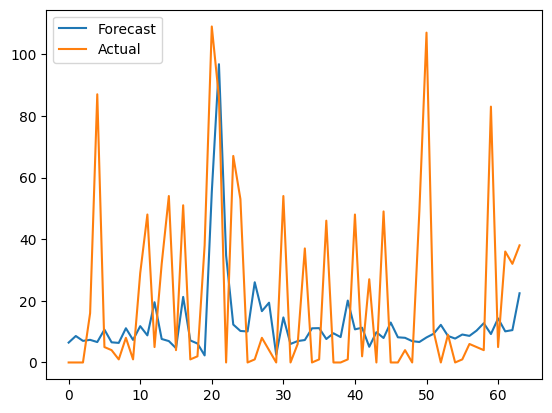

In [218]:
import matplotlib.pyplot as plt

buckets = 64
forecasted_totals = np.sum(forecasted_weekly_totals.reshape(-1, weeks//buckets), axis=1)
actual_totals = np.sum(actual_weekly_totals.reshape(-1, weeks//buckets), axis=1)

plt.plot(range(buckets), forecasted_totals, label='Forecast')
plt.plot(range(buckets), actual_totals, label='Actual')
plt.legend()
plt.show()